# Assignment 3: Implementation, Analysis, Performance Evaluation and Comparison of Deep Convolutional Neural Networks for Image Classification

**Objective:** The objective of this assignment is to implement a deep convolutional neural network (CNN) for the identification of flower types. The provided dataset consists of five classes of flowers, namely chamomile, tulip, rose, sunflower, and dandelion. 

**Tasks:**
To complete this assignment, please submit a single notebook that includes the implementation and outputs of the following seven steps.
Provide answers for each sub-question by thorough analysis and extensive experimental investigation using the provided dataset. In other words, your answers should be backed by experimental analysis of your models and the dataset. Please ensure that the notebook retain the outputs. Failure to do so will result in zero marks for the corresponding steps in which no output is displayed.

**1. Prepare and Preprocess the data. (15 points)**

* What is the total number of images in the dataset, and how are they distributed across the five flower types?

    *As seen in the outputs of the cell below, the dataset contains 4317 images, distributed among five classes: daisy (764), dandelion (1052), rose (784), sunflower (733) and tulip (984).*
* Do we need to implement techniques to balance the distribution of images across various flower types, such as oversampling or undersampling?

    *The five classes contain different number of images, and hence the dataset is **slightly** imbalanced. Undersampling is out of question, as the dataset is quite small and we would not want to lose any more data. We could perform oversampling by 1. Getting new images for the under-represented classes from the source, 2. Augmenting them by applying image transformations such as shifting, rotating, color variations etc., or 3. Generating new images using GANs etc. However, since the imbalance here is not so drastic, I shall rely on using **class weights** while training. Applying appropriate class weights takes care of penalizing the loss function accordingly for each class, resulting in unbiased results.*
* What are the dimensions (height and width) of the images in the dataset, and is there any variation among different flower types?

    *The images have a wide range of dimensions with a mean height of 339 and mean width of 252. Moreover, the maximum height is 1024 while minimum is 134.*

* What preprocessing techniques should be applied, such as resizing, normalization or standardization and why?
    
    *Since the variations in dimensions among various images/classes is pretty high, we need to normalize the dimensions. In the preprocessing functions we use below, the images are loaded, and resized to 224x224. The pixel values are further normalized by dividing by 255. This not only ensure consistency among inputs, but also speeds up the training. Also, for a complex model like the CNN we are using, 4k images is not enough data at all, hence I will also be augmenting the training set.*
    
* How would you split the dataset into training, validation and testing sets, and in what ratios?
    
    *I have split the dataset with 60% of images in training set, and 20% each in validation and testing sets.*

In [1]:
#Step 1 implementation
#Hint: Take the help of split-folder python library
import splitfolders

def load_and_split_data(input_folder, output_folder, split_ratio=(0.6, 0.2, 0.2)):
    splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=split_ratio)

# Example usage
load_and_split_data('data/', 'split_data/')

Copying files: 4317 files [00:00, 6117.68 files/s]


In [18]:
from PIL import Image
import os

def explore_dataset(dataset_path):
    class_distribution = {}
    image_dimensions = set()

    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        images = os.listdir(class_path)
        class_distribution[class_folder] = len(images)
        for image in images:
            with Image.open(os.path.join(class_path, image)) as img:
                image_dimensions.add(img.size)

    total_images = sum(class_distribution.values())
    return total_images, class_distribution, image_dimensions

total_images, class_distribution, image_dimensions = explore_dataset('data/')
print("Total images:", total_images)
print("Class distribution:", class_distribution)
print("Unique image dimensions:", image_dimensions)

Total images: 4317
Class distribution: {'rose': 784, 'daisy': 764, 'dandelion': 1052, 'sunflower': 733, 'tulip': 984}
Unique image dimensions: {(320, 239), (320, 248), (240, 139), (320, 257), (198, 240), (176, 240), (187, 240), (240, 224), (500, 300), (500, 309), (500, 318), (500, 327), (160, 240), (500, 336), (240, 98), (320, 216), (217, 240), (320, 225), (320, 234), (320, 243), (179, 240), (500, 286), (240, 219), (500, 295), (240, 228), (500, 304), (240, 237), (500, 313), (500, 322), (320, 211), (500, 407), (320, 220), (320, 229), (240, 120), (500, 425), (320, 238), (500, 434), (239, 240), (228, 240), (500, 281), (240, 214), (500, 290), (240, 223), (500, 299), (240, 232), (500, 308), (190, 240), (320, 215), (320, 224), (500, 429), (152, 240), (1024, 187), (500, 267), (209, 240), (500, 285), (240, 218), (240, 227), (182, 240), (171, 240), (500, 388), (320, 210), (320, 219), (500, 253), (240, 186), (240, 195), (500, 271), (240, 204), (240, 213), (201, 240), (240, 222), (231, 240), (320

In [19]:
import numpy as np
heights = []
widths = []
for height, width in image_dimensions:
    heights.append(height)
    widths.append(width)
np.mean(heights), np.std(heights), np.max(heights), np.min(heights)

(339.3264248704663, 138.1430218399517, 1024, 134)

In [20]:
np.mean(widths), np.std(widths), np.max(widths), np.min(widths)

(252.94041450777203, 64.34423352090651, 442, 80)

In [26]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Paths to the split datasets
train_dir = 'split_data/train'
val_dir = 'split_data/val'
test_dir = 'split_data/test'

# Define the parameters for the datasets
batch_size = 8
image_size = (224, 224)

# Define a function to scale the images
def preprocess(image, label):
    return tf.cast(image, tf.float32) / 255., label

# Create a dataset of image paths and labels for training
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed=123
)

def augment_and_duplicate(image, label):
    # Create a list to hold the original and augmented images
    images = [image]  

    # Augmentation 1: Horizontal flip
    flipped_image = tf.image.random_flip_left_right(image)
    images.append(flipped_image)

    # Augmentation 2: Random brightness
    bright_image = tf.image.random_brightness(image, max_delta=0.2)
    images.append(bright_image)

    return images, [label] * len(images)  

train_dataset = train_dataset.map(augment_and_duplicate).unbatch()
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(1)

# Create a dataset of image paths and labels for validation
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed=123
)
val_dataset = val_dataset.map(preprocess).shuffle(buffer_size=1000).prefetch(1)

# Create a dataset of image paths and labels for testing
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False  # Important for test set to evaluate on the same data order
)
test_dataset = test_dataset.map(preprocess).shuffle(buffer_size=1000).prefetch(1)

Found 2588 files belonging to 5 classes.
Found 860 files belonging to 5 classes.
Found 869 files belonging to 5 classes.


In [5]:
# Calculating class weights to mitigate the effect of imbalanced classes.
total_samples = sum(class_distribution.values())
num_classes = len(class_distribution)

class_weights = {class_name: (total_samples / (num_classes * count)) for class_name, count in class_distribution.items()}

print(class_weights)

{'rose': 1.1012755102040817, 'daisy': 1.1301047120418848, 'dandelion': 0.820722433460076, 'sunflower': 1.1778990450204638, 'tulip': 0.8774390243902439}


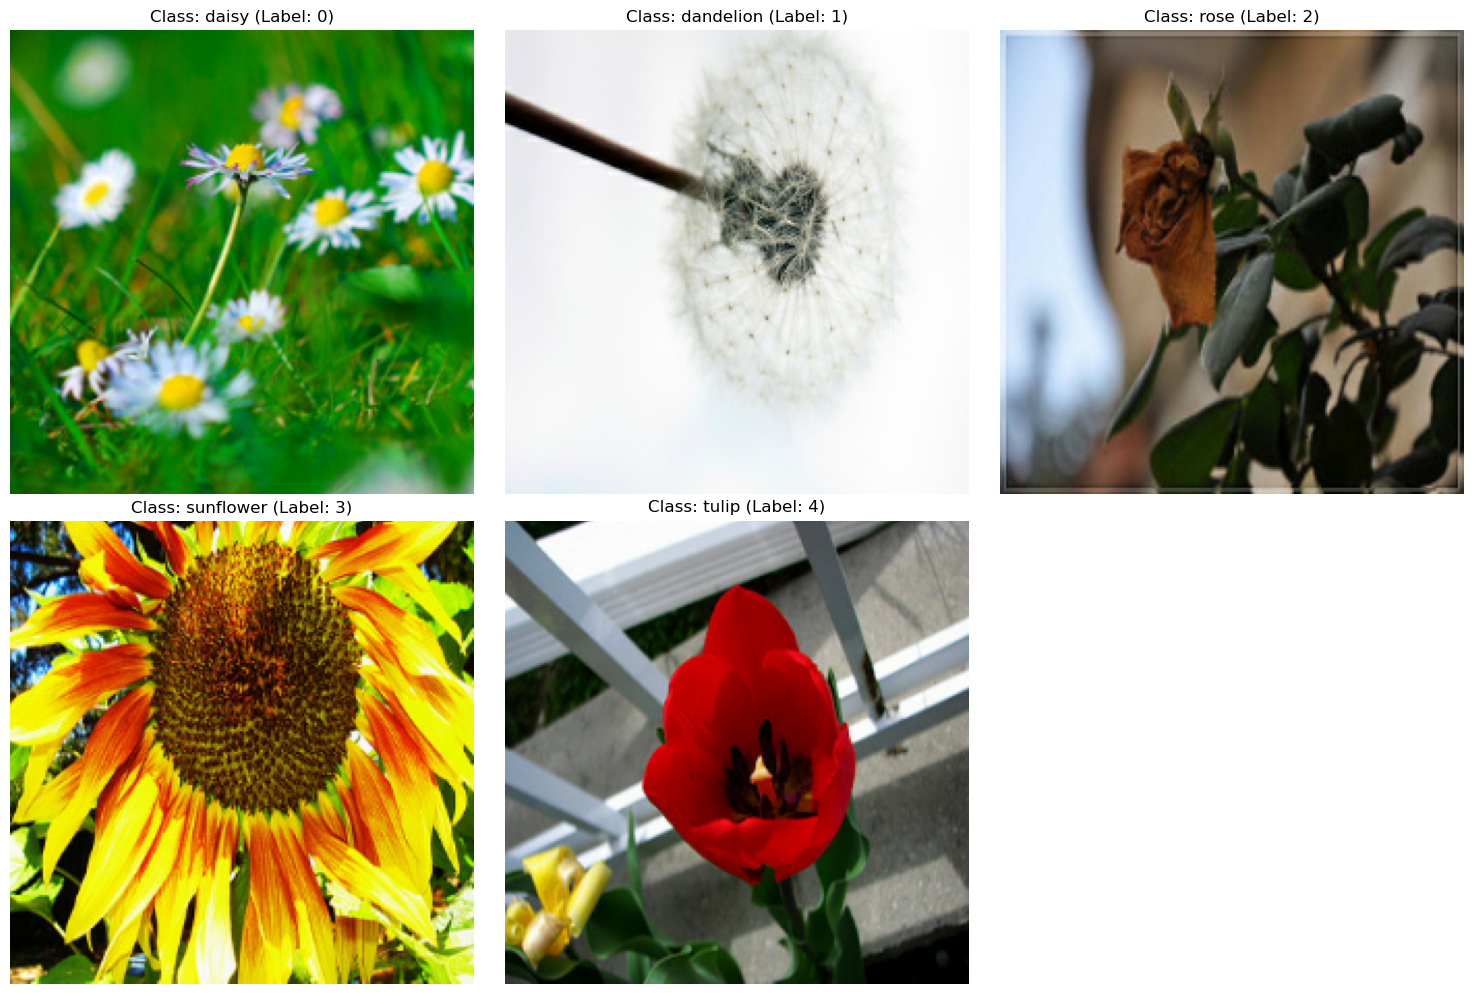

In [30]:
import numpy as np
import tensorflow as tf

def display_one_image_per_class(dataset, class_names):
    # Store one image per class
    images_per_class = {}
    labels_per_class = {}

    # Iterate through the dataset to find one image per class
    for images, labels in dataset.take(len(class_names) * 5):  # Check multiple batches
        for image, label in zip(images, labels):
            label_index = np.argmax(label)  # Convert one-hot to index
            if label_index not in images_per_class:
                # Directly use the numpy array and ensure it's normalized to [0, 1]
                if tf.reduce_max(image) > 1:
                    image = image / 255.0
                images_per_class[label_index] = image.numpy()
                labels_per_class[label_index] = label_index
            if len(images_per_class) == len(class_names):  # Stop once we have one per class
                break
        if len(images_per_class) == len(class_names):
            break

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Set up the plotting area
    axs = axs.flatten()  # Flatten to make indexing easier
    for i, ax in enumerate(axs):
        if i < len(class_names):
            ax.imshow(images_per_class[i])  # Display the image
            ax.title.set_text(f"Class: {class_names[i]} (Label: {labels_per_class[i]})")
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off unused subplots

    plt.tight_layout()
    plt.show()

train_dir = 'split_data/train'
class_names = sorted(os.listdir(train_dir))

# Assuming class_names and train_dataset are properly defined
display_one_image_per_class(train_dataset, class_names)

In [7]:
class_weights_dict = {2: 1.1012755102040817, 0: 1.1301047120418848, 1: 0.820722433460076, 3: 1.1778990450204638, 4: 0.8774390243902439}

**2. Implement the given CNN architecture. Make necessary changes in the final layers for it to work on the number of classes in the given dataset. Use an input image size of $224 \times 224 \times 3$ (10 points)**
<img src='resources/CNN.png' alt='given CNN'>

In [8]:
from tensorflow.keras import layers, models

# Define the CNN architecture
def build_model(input_shape):
    model = models.Sequential()

    # First block: 2 Conv layers followed by pooling
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second block: 2 Conv layers followed by pooling
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third block: 3 Conv layers followed by pooling
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth block: 3 Conv layers followed by pooling
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening the convolutions
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))

    # Output layer: Change here to match the number of classes
    model.add(layers.Dense(5, activation='softmax'))

    return model

# Create the CNN model
cnn_model = build_model((224, 224, 3))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

**3. Train the model. (15 Points)** 

* What is your approach for selecting the appropriate hyperparameters for the model training, such as the learning rate, number of epochs, batch size, and optimizer?

* What methods do you use for monitoring the training progress and performance of the model and why?

* What metrics would you prefer to measure the performance, such as accuracy, precision, recall, F1 score, or ROC-AUC and why?

In [1]:
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Setup callbacks
callbacks = [
    ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=10),
    TensorBoard(log_dir='./logs')
]

# Train the model
history = cnn_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weights_dict,  # Ensure this is defined appropriately
    callbacks=callbacks,
    batch_size=1
)

# To launch tensorboard:
%load_ext tensorboard
%tensorboard --logdir ./logs

NameError: name 'cnn_model' is not defined

**4. Report the results. (10 points)**

* What is the final accuracy of the model on the validation set, and how does it compare to the training accuracy?

* What is the confusion matrix for the model on the validation set, and which flower types are the most difficult to classify?

* How does the model perform on individual flower types, and are there any particular images that the model struggles to classify?

* What is the rough model complexity?

* Is the model's large size contributing to any challenges or constraints in its performance on the given dataset.


In [2]:
#Step 4 implementation

**5. Test the model by giving it a picture taken by your own phone camera. (10 points)**

* How can the accuracy of the model on the picture taken by your own phone camera be evaluated?

* What can be done if the model does not perform well on the picture taken by your own phone camera?


In [3]:
#Step 5 implementation

**6. Use the same architecture but now train two different models one with L1 or L2 regularization, and one with batch normalization. (20 points)**


* Based on the results of the regularized and batch normalized models, how effective are L1 or L2 regularization and batch normalization techniques? How do they impact the model's performance, convergence, size, and inference time?

* How do the learned weights of the L1 or L2 regularized models compare to the baseline model? Provide any insights on the differences in the learned weights and what it implies for the model's performance and interpretability?

* What insights can be drawn from the comprehensive analysis of the regularized and batch normalized models regarding the use of regularization and normalization techniques in training machine learning models?

In [4]:
#Step 6 implementation

**7. Improve the accuracy by trying something extra. (20 points)** 

* By incorporating additional training strategies such as regularization techniques like dropout, data augmentation, and batch or layer normalization, can the accuracy of the model be improved? 

* Modify the given model architecture to improve the accuracy over the baseline? You can modify the model architecture by adding or removing layers, changing the number of filters, or adding skip connections. 


* Use transfer learning to fine-tune an existing pre-trained model to improve accuracy?  What approach will you use for transfer learning: feature extraction or fine-tuning and why?



In [5]:
#Step 7 implementation